# WINE RATINGS AND REVIEWS

**Data Source**

The dataset was obtained from kaggle.com

**Data Description**

The dataset contains information about various variety of wine like country, region and province the wine was manufactured, price of the wine. It also contains tasters' reviews on the wine.

**Goal of the project**

1. Create a model to preditct the points of the various types of wines

2. Perform text mining to see how various words affect the ratings of the wine.

**Outcome**

I performed text mining using the tidytext package and did a lasso regression on the words to see their effects on the ratings.

I also did a lasso regression on the rest of the dataset and build a model to predict the ratings of the wine.

There wasn't enough predictor variables but i built a decent model with the following outcomes.

  1. **Mean Absolute Error (MAE): 1.77**
  
  2. **Root Mean Squared Error(RMSE): 2.24**
  
  3. **R-squared(rsq): 0.421**


**Import the dataset**

In [1]:
wine_ratings <- read.csv("../input/wine-reviews/winemag-data-130k-v2.csv", stringsAsFactors = FALSE)


In [2]:
#Load in the libraries
library(tidyverse)
library(tidytext)
library(widyr)
library(igraph)
library(ggraph)
library(tidymodels)
library(glmnet)
library(Matrix)
library(broom)
library(vip)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


── Attaching packages ────────────────────────────────────── tidymodels 0.1.2 ──

✔ broom     0.7.2      ✔ recipes   0.1.

In [3]:
#Quick look at a summary of the dataset.
str(wine_ratings)

'data.frame':	129971 obs. of  14 variables:
 $ X                    : int  0 1 2 3 4 5 6 7 8 9 ...
 $ country              : chr  "Italy" "Portugal" "US" "US" ...
 $ description          : chr  "Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering un"| __truncated__ "This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy r"| __truncated__ "Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp ac"| __truncated__ "Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with note"| __truncated__ ...
 $ designation          : chr  "Vulkà Bianco" "Avidagos" "" "Reserve Late Harvest" ...
 $ points               : int  87 87 87 87 87 87 87 87 87 87 ...
 $ price                : num  NA 15 14 13 65 15 16 24 12 27 ...
 $ province             : chr  "Sicily & Sardinia" "Douro" "Oregon" "

Let us plot the points variable and see its distribution.

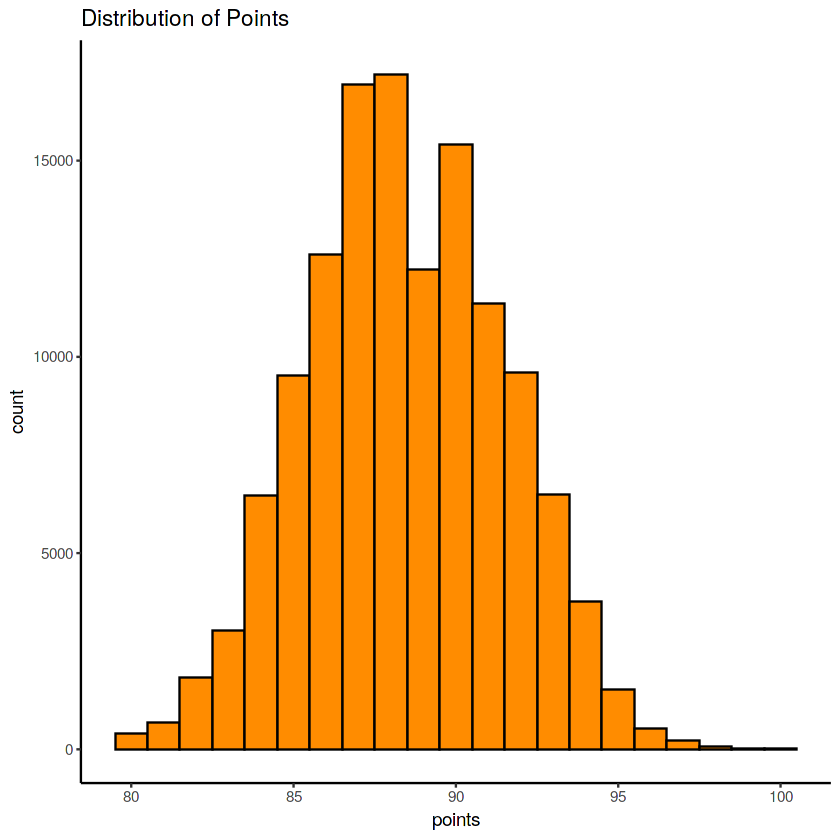

In [4]:
wine_ratings %>% 
  ggplot(aes(points)) +
  geom_histogram(binwidth = 1, color="black", fill="darkorange") +
  theme_classic() +
  ggtitle("Distribution of Points")

Majority of points are between 86-89. The table below shows their accurate distribution.

In [5]:
wine_ratings %>% 
  group_by(points) %>% 
  count(points, sort=T) %>% 
  head()

points,n
<int>,<int>
88,17207
87,16933
90,15410
86,12600
89,12226
91,11359


# DATA CLEANING

In [6]:
#Let us look at the missing variables
Missing_Indices <- sapply(wine_ratings, function(x)sum(is.na(x)))
Missing_Values <- data.frame(Name=names(wine_ratings), Indices=Missing_Indices)
Missing_Values[Missing_Values$Indices>0,]

,Name,Indices
,<fct>,<int>
price,price,8996


It seems like only price has NA values but also some columns have blank values.

We will replace the missing values in the price column with its mean value.

In [7]:
mean<-mean(wine_ratings$price, na.rm =T)

#round the mean to o decimal places.
rounded <- round(mean,0)

#replace the NA values
wine_ratings[is.na(wine_ratings$price),"price"] <- rounded

mean(wine_ratings$price)

[1] 35.33824

In [8]:
wine_ratings %>% 
  count(region_1,sort=T) %>% 
  head(10)
 
wine_ratings %>% 
  count(region_2,sort=T) %>% 
  head(10)
  

,region_1,n
,<chr>,<int>
1,,21247
2,Napa Valley,4480
3,Columbia Valley (WA),4124
4,Russian River Valley,3091
5,California,2629
6,Paso Robles,2350
7,Mendoza,2301
8,Willamette Valley,2301
9,Alsace,2163


,region_2,n
,<chr>,<int>
1,,79460
2,Central Coast,11065
3,Sonoma,9028
4,Columbia Valley,8103
5,Napa,6814
6,Willamette Valley,3423
7,California Other,2663
8,Finger Lakes,1777
9,Sierra Foothills,1462


Region 1 has 21247 missing values out of 129971 variables which is 16% of the missing data.

Region 2 has 79460 missing values out of 129971 variables which is 60% of the missing data.

We will use region 1 for our analysis.

We will replace the missing values with their respective province names.

In [9]:
replacement_provinces <- wine_ratings %>% 
  select(province, region_1) %>% 
  filter(region_1=="")

wine_ratings[wine_ratings$region_1=="","region_1"] <- replacement_provinces$province

We will replace the missing values in the province column with their respective country names.

In [10]:
replacement_countries <- wine_ratings %>% 
  select(country, province) %>% 
  filter(province=="")

wine_ratings[wine_ratings$province=="","province"] <- replacement_countries$country

The missing designation values we will replace with None.

In [11]:
wine_ratings[wine_ratings$designation=="","designation"] <- "None"

The missing taster name and country names missing values we will replace with None.

In [12]:
wine_ratings[wine_ratings$taster_name=="","taster_name"] <- "None"
wine_ratings[wine_ratings$country=="","country"] <- "None"

We will replace the missing variety value with the mode.

In [13]:
wine_ratings %>% 
  count(variety, sort = T) %>% 
  head(10)

wine_ratings[wine_ratings$variety=="","variety"] <- "Pinot Noir"

,variety,n
,<chr>,<int>
1,Pinot Noir,13272
2,Chardonnay,11753
3,Cabernet Sauvignon,9472
4,Red Blend,8946
5,Bordeaux-style Red Blend,6915
6,Riesling,5189
7,Sauvignon Blanc,4967
8,Syrah,4142
9,Rosé,3564


# DATA MINING

In the title column, the description has the years when the wines were made. Let's extract them.

In [14]:
wine_ratings <- wine_ratings %>% 
  extract(title, "year", "([12][90]\\d\\d)", remove = FALSE, convert = TRUE)

wine_ratings %>% 
  group_by(year) %>% 
  count(year, sort=T) 

year,n
<int>,<int>
2013,15873
2012,15746
2014,15581
2011,12551
2010,12165
2015,10051
2009,9875
2008,7439
2007,7053


Let us plot the year column to see its distribution. 

Most years are after 2000 so we will filter the dataset.

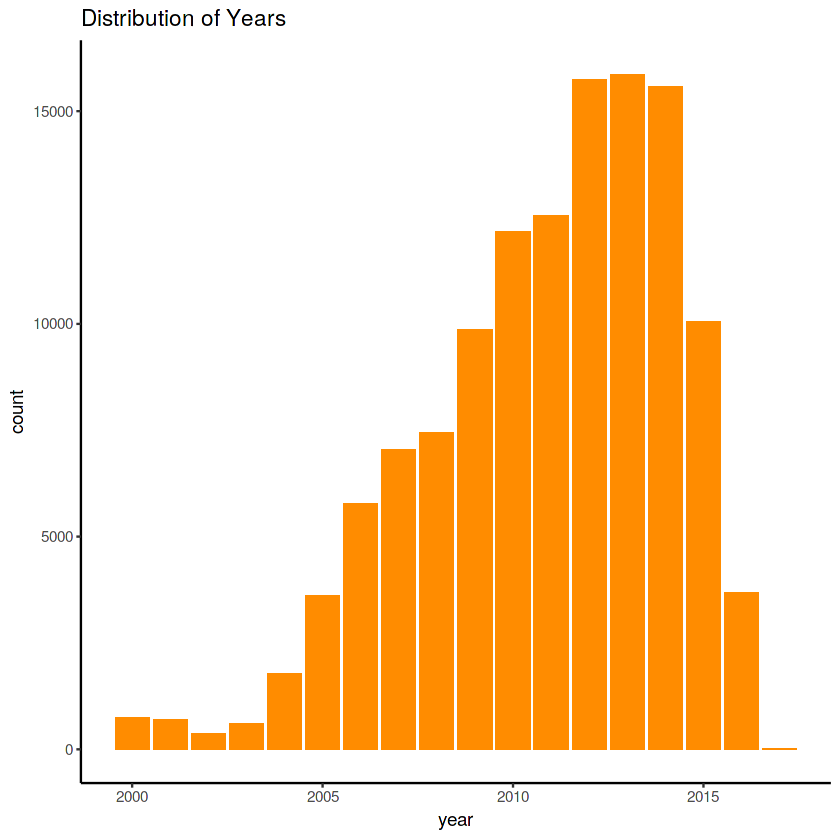

In [15]:
wine_ratings %>% 
  filter(year >= 2000 ) %>% 
  group_by(year) %>% 
  ggplot(aes(year)) +
  theme_classic() +
  geom_bar(fill="darkorange") +
  ggtitle("Distribution of Years")

# EDA

**What are the top wine producing countries?**

`summarise()` ungrouping output (override with `.groups` argument)



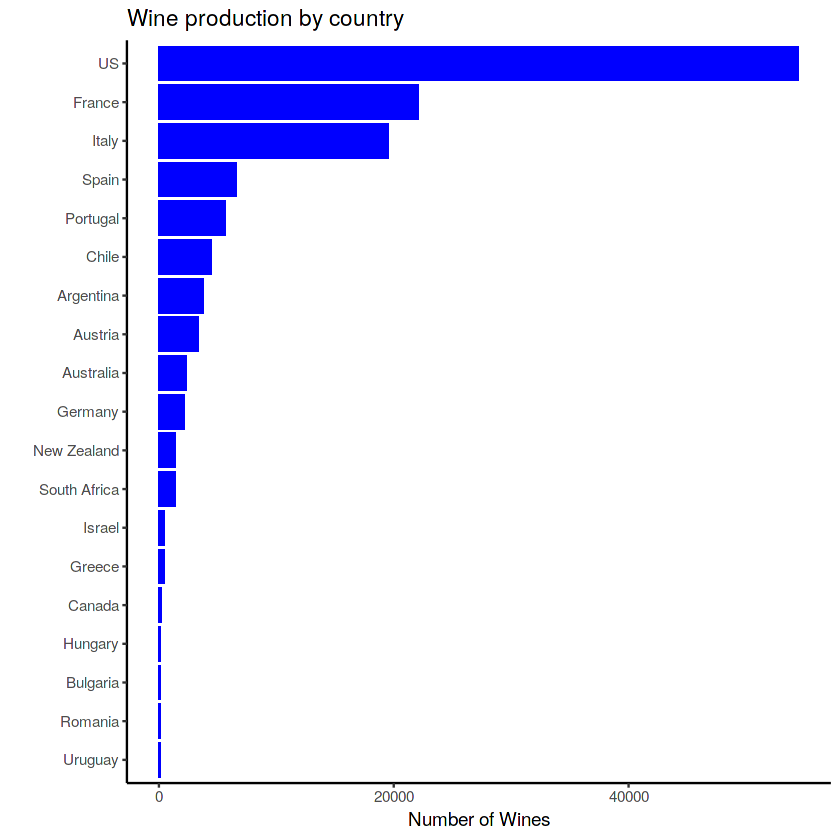

In [16]:
wine_ratings %>% 
  group_by(country) %>% 
  summarise(n = n()) %>% 
  filter(n>100) %>% 
  arrange(desc(n)) %>% 
  ggplot(aes(fct_reorder(country, n), n)) +
  geom_bar(stat = "identity", fill = "blue") +
  labs(title = "Wine production by country",
       x = "",
       y = "Number of Wines") +
  theme_classic() +
  coord_flip()

**What are the top wine producing provinces?**

`summarise()` ungrouping output (override with `.groups` argument)



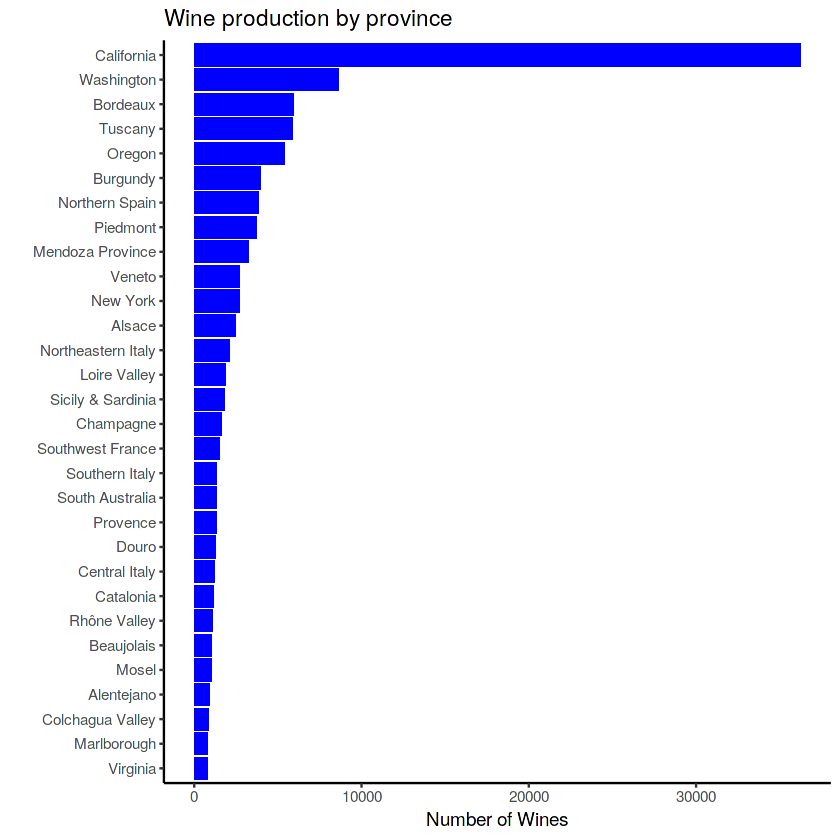

In [17]:
wine_ratings %>% 
  group_by(province) %>% 
  summarise(n = n()) %>% 
  filter(n>700) %>% 
  arrange(desc(n)) %>% 
  ggplot(aes(fct_reorder(province, n), n)) +
  geom_bar(stat = "identity", fill = "blue") +
  labs(title = "Wine production by province",
       x = "",
       y = "Number of Wines") +
  theme_classic() +
  coord_flip()

**What are the top wine producing regions?**

`summarise()` ungrouping output (override with `.groups` argument)



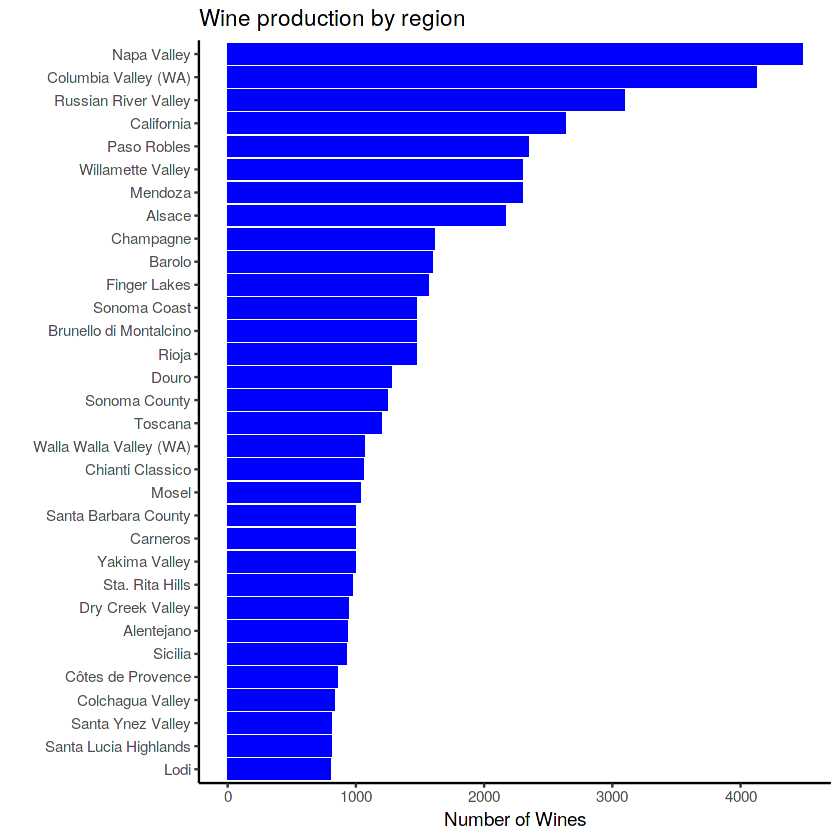

In [18]:
wine_ratings %>% 
  group_by(region_1) %>% 
  summarise(n = n()) %>% 
  filter(n>800) %>% 
  arrange(desc(n)) %>% 
  ggplot(aes(fct_reorder(region_1, n), n)) +
  geom_bar(stat = "identity", fill = "blue") +
  theme_classic() +
  labs(title = "Wine production by region",
       x = "",
       y = "Number of Wines") +
  coord_flip()

**Which countries have the highest average rating?**

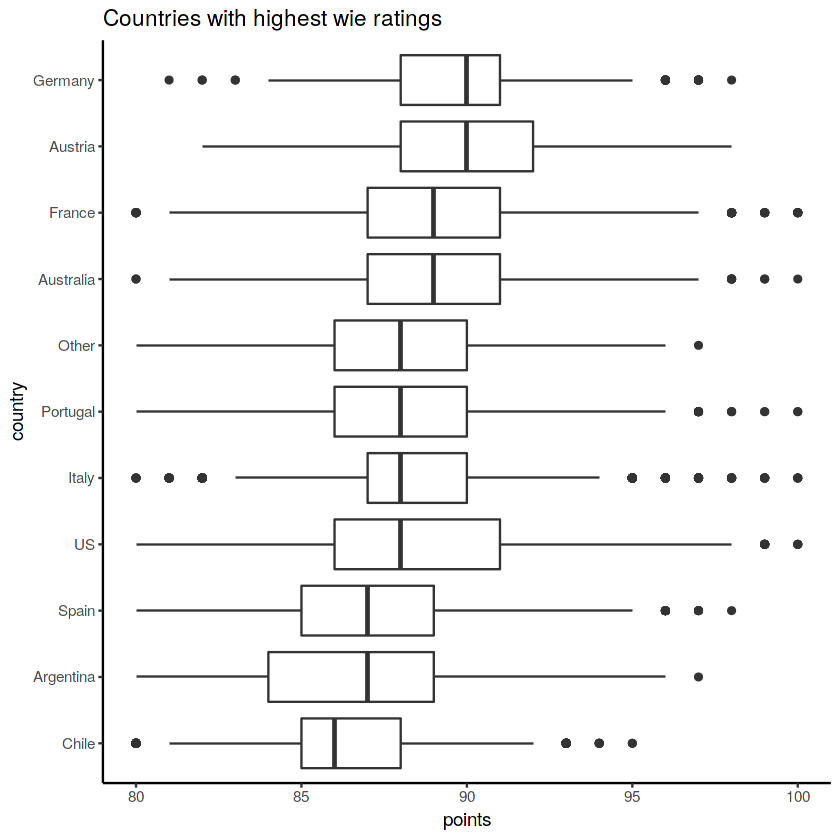

In [19]:
wine_ratings %>% 
  mutate(country = fct_relevel(fct_lump(country,10), "US")) %>% 
  mutate(country = fct_reorder(country, points)) %>% 
  ggplot(aes(country, points)) +
  geom_boxplot() +
  theme_classic() +
  coord_flip() +
  ggtitle("Countries with highest wie ratings")

Chile and Argentina have the lowly rated wines.

Germany and Australia have the highly rated wines.


**Price of wines in countries**

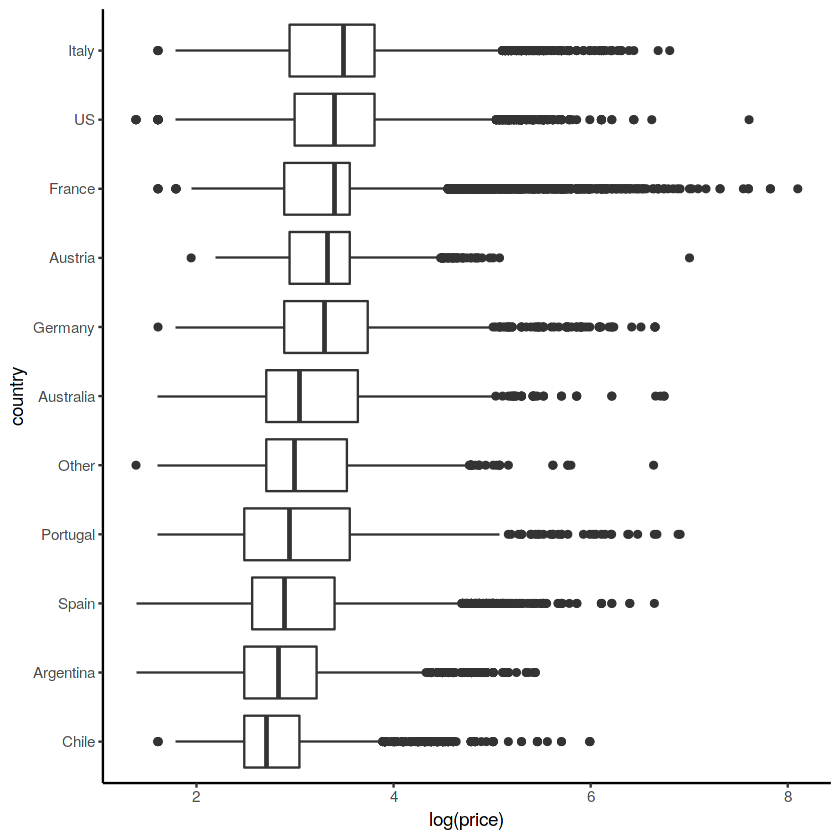

In [20]:
wine_ratings %>% 
  mutate(country = (fct_lump(country,10))) %>% 
  mutate(country = fct_reorder(country, price)) %>% 
  ggplot(aes(country, log(price))) +
  geom_boxplot() +
  theme_classic() +
  coord_flip()

Italy has the highest average mean price of wine. Chile has the lowest.
 
But this is a boxplot of the top 10 highest prices.

# The response variable, Price.

**Whats the distribution of price?**

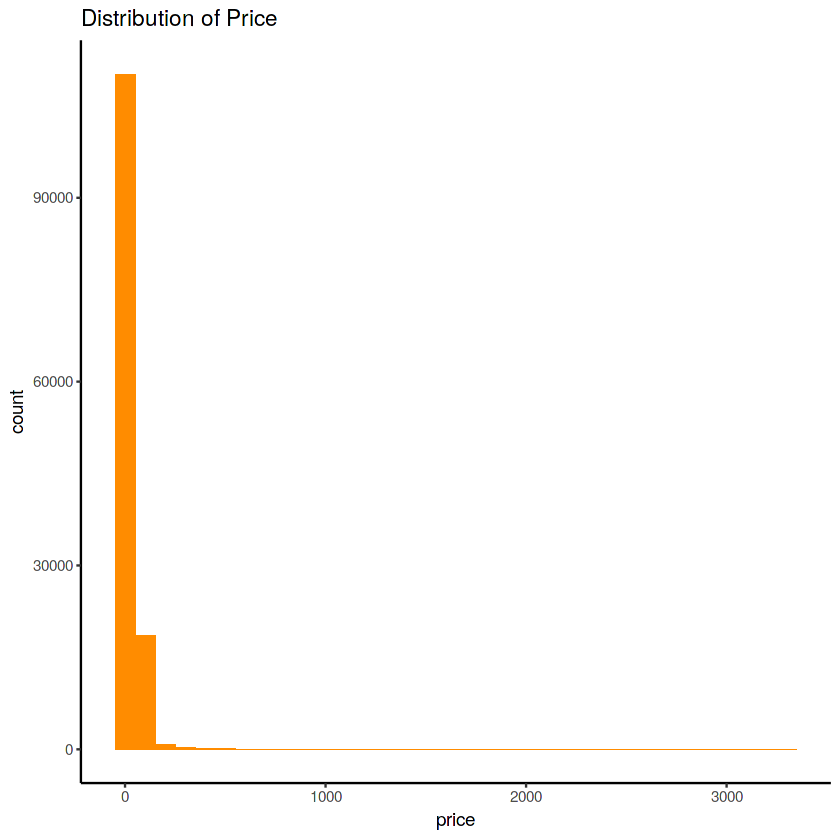

In [21]:
wine_ratings %>% 
  ggplot(aes(price)) +
  geom_histogram(binwidth = 100, fill="darkorange") +
  theme_classic() +
  ggtitle("Distribution of Price")

Let us normalise the distribution by finding the log of the price.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



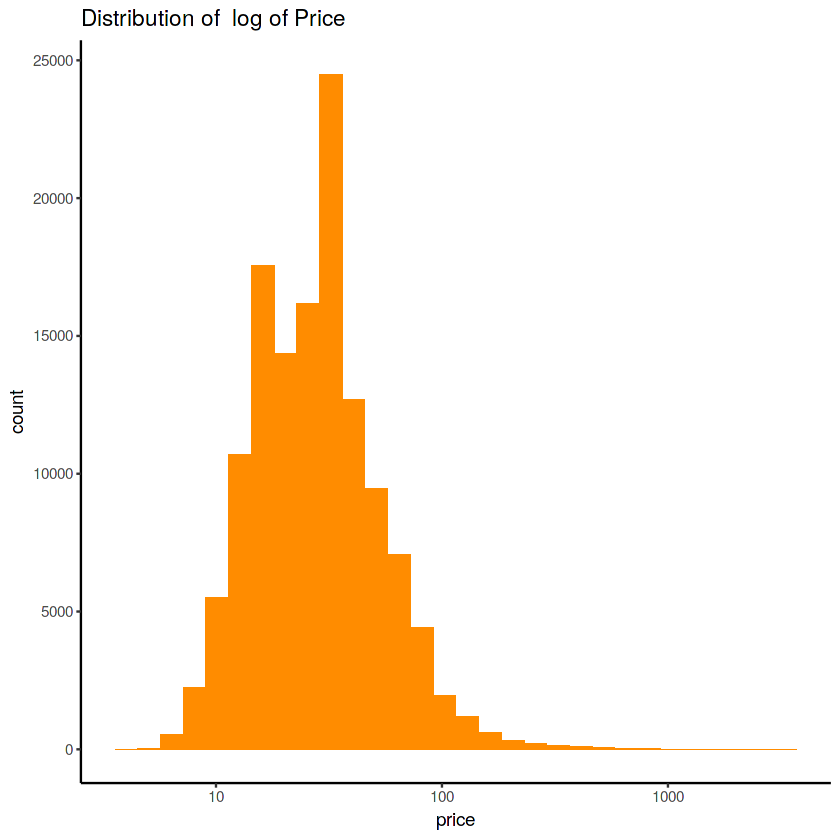

In [22]:
wine_ratings %>% 
  ggplot(aes(price)) +
  geom_histogram( fill="darkorange") +
  theme_classic() +
  ggtitle("Distribution of  log of Price") +
  scale_x_log10()

**What's the relationship between price and points?**

Warning message:
“Ignoring unknown parameters: aplha”
`geom_smooth()` using formula 'y ~ x'



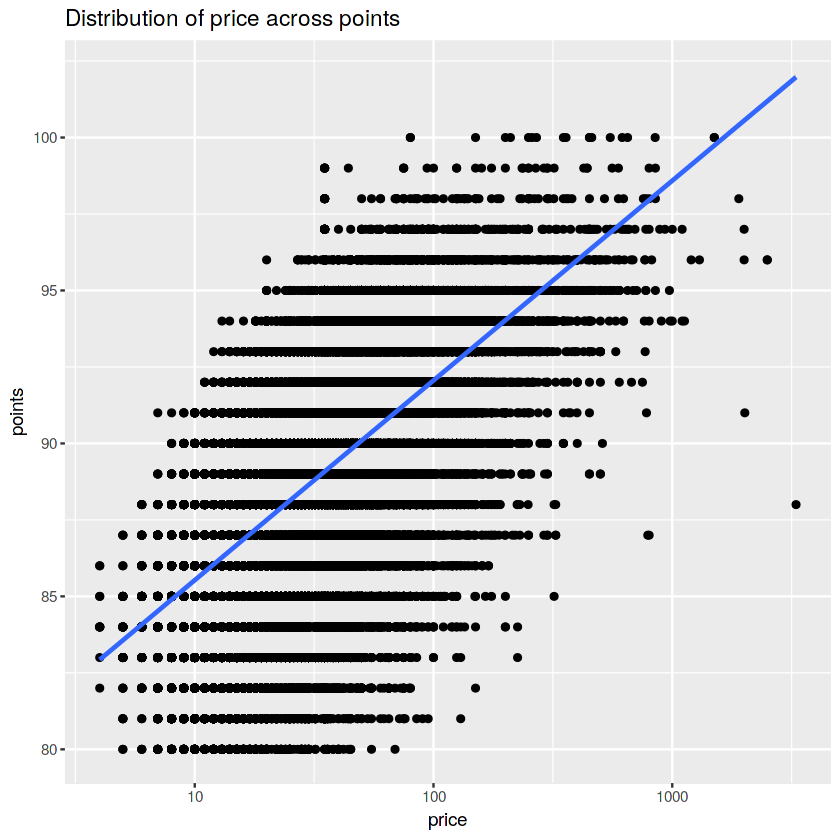

In [23]:
wine_ratings %>% 
  ggplot(aes(price,points)) +
  geom_point(aplha=0.1) +
  geom_smooth(method = "lm") +
  scale_x_log10() +
  ggtitle("Distribution of price across points")

In [24]:
wine_ratings %>% 
  lm(points ~ log2(price), data=.) %>% 
  summary()


Call:
lm(formula = points ~ log2(price), data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.9747  -1.5309   0.1372   1.7563   9.9175 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 79.000444   0.036369  2172.2   <2e-16 ***
log2(price)  1.965586   0.007434   264.4   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.451 on 129969 degrees of freedom
Multiple R-squared:  0.3498,	Adjusted R-squared:  0.3498 
F-statistic: 6.991e+04 on 1 and 129969 DF,  p-value: < 2.2e-16


Every time the price doubles, the expected number of points goes up by 2.

# Taster name

**Do certain tasters give higher ratings than others?**

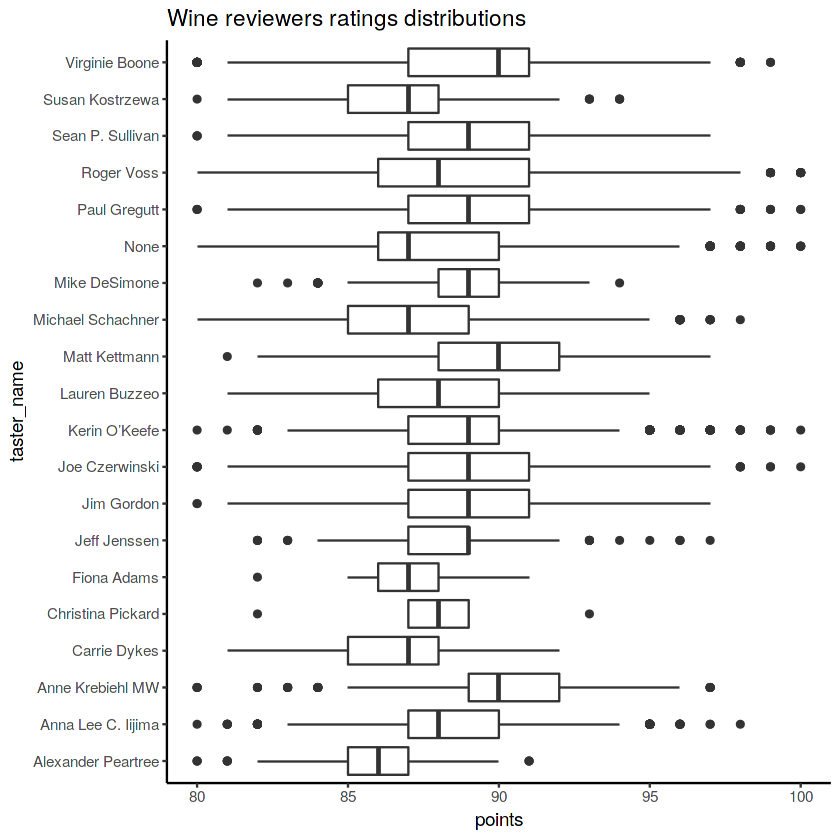

In [25]:
wine_ratings %>% 
  group_by(taster_name) %>% 
  ggplot(aes(taster_name,points)) +
  geom_boxplot() +
  theme_classic() +
  coord_flip() +
  ggtitle("Wine reviewers ratings distributions")

The lowest average ratings were given by Alexander Peartree. The highest were given by Virginie Boone and Anne k MW.

4 reviewers gave a perfect score of 100.

1.Joe Czerwinski

2.Kerin Keefe

3.Paul Gregett

4.Voger Ross

**Does rating of the reviewers depend on the price of the wine they taste?**

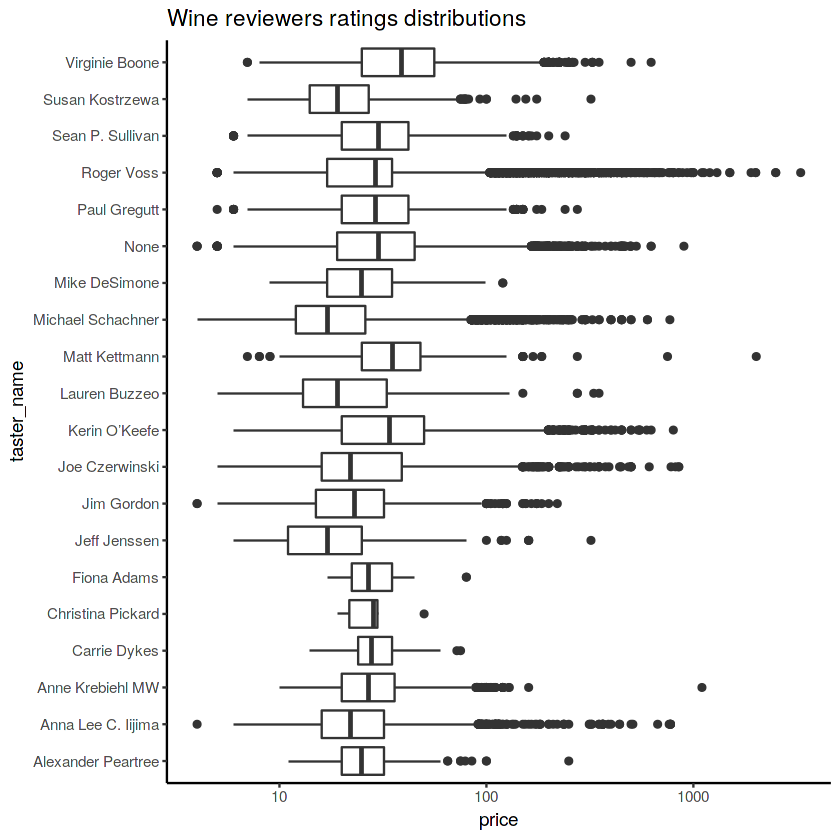

In [26]:
wine_ratings %>% 
  group_by(taster_name) %>% 
  ggplot(aes(taster_name,price)) +
  geom_boxplot() +
  coord_flip() +
  scale_y_log10() +
  theme_classic() +
  ggtitle("Wine reviewers ratings distributions")

There is no significant difference in average price of the wine they tasted.

Roger Voss has tasted a couple of very expensive wines. He has also tasted the most expensive wine hence the perfect score of 100.

# Year

**Is there a trend in year and distribution of points?**

`summarise()` ungrouping output (override with `.groups` argument)



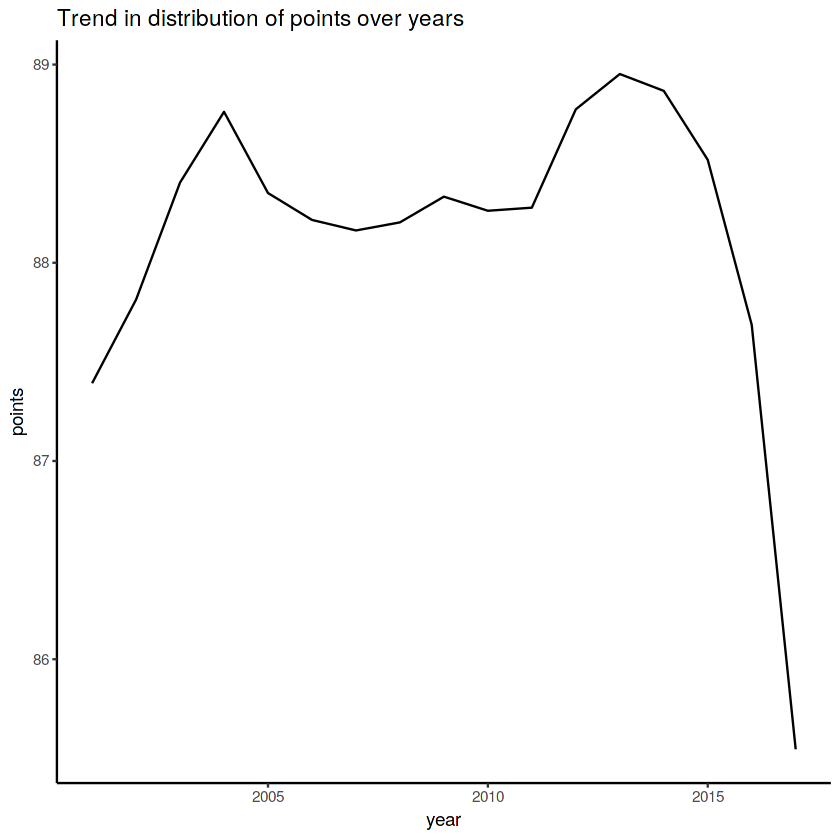

In [27]:
wine_ratings %>% 
  filter(year>2000) %>% 
  group_by(year)  %>% 
  summarise(points = mean(points)) %>% 
  ggplot(aes(year,points)) +
  geom_line() +
  theme_classic() +
  ggtitle("Trend in distribution of points over years ")

In [28]:
wine_ratings %>% 
  filter(year>2000) %>% 
  group_by(year)  %>% 
  summarise(points = mean(points))

`summarise()` ungrouping output (override with `.groups` argument)



year,points
<int>,<dbl>
2001,87.39219
2002,87.81421
2003,88.40468
2004,88.76156
2005,88.35179
2006,88.21622
2007,88.16305
2008,88.20379
2009,88.33357


There is a slight upward incraese in ratings every year. There is a drop in 2017 since it had little number of variables.

`summarise()` ungrouping output (override with `.groups` argument)



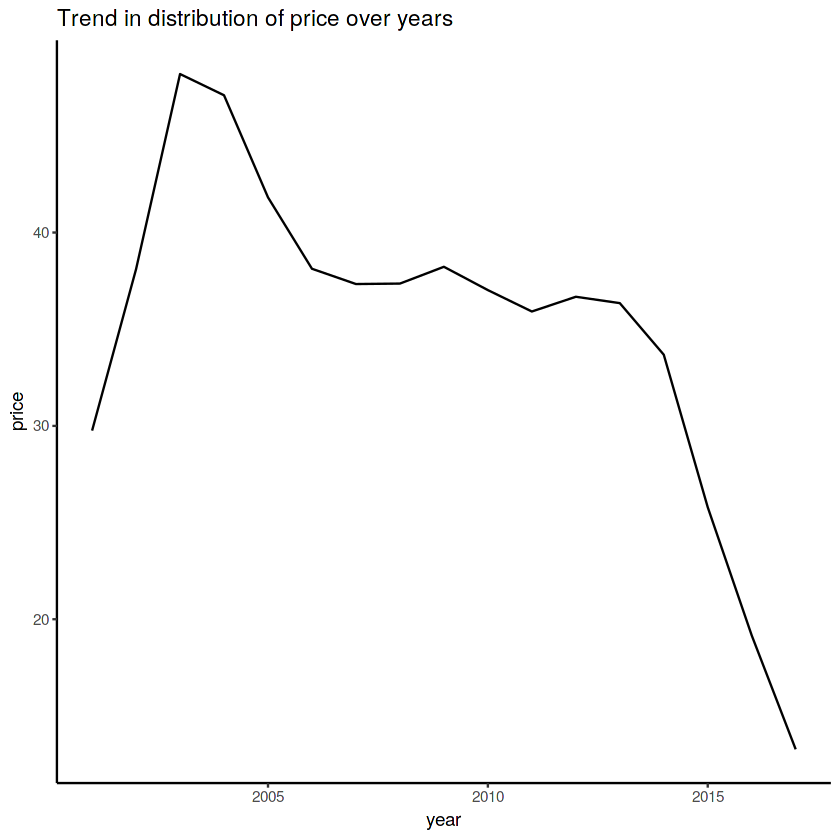

In [29]:
wine_ratings %>% 
  filter(year>2000) %>% 
  group_by(year)  %>% 
  summarise(price = mean(price)) %>% 
  ggplot(aes(year,price)) +
  geom_line() +
  theme_classic() +
  ggtitle("Trend in distribution of price over years")

# TEXT MINING

We will use the tidytext package to analyse the description.

**STEPS**

1. We will begin by placing each word in its own row.

2. Removal of stop words. stop words are words like a, the, it.... which don't give as any insights.

3. Removal of common words like wine, drink.

In [30]:
wine_rating_words <- wine_ratings %>% 
  select(description) %>% 
  mutate(wine_id = row_number()) %>% 
  unnest_tokens(output = word, input=description) %>% 
  anti_join(stop_words, by = "word")  %>% 
  filter(!word %in% c("wine", "drink")) %>% 
  distinct()

Let us plot the most commonly used words.

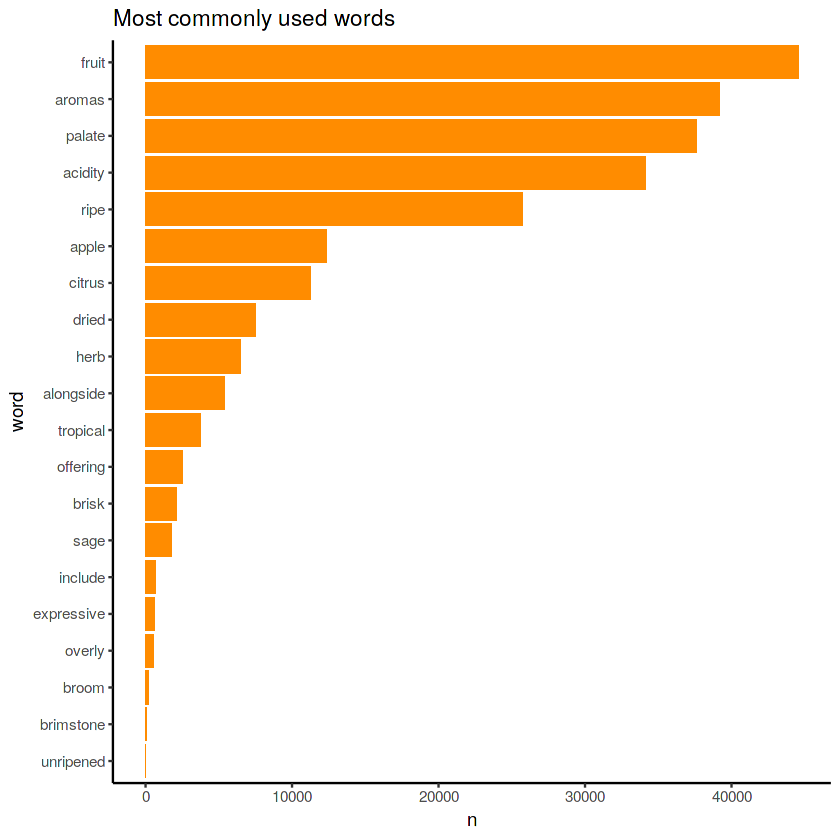

In [31]:
wine_rating_words %>% 
  add_count(word) %>% 
  head(20) %>% 
  mutate(word = fct_reorder(word, n)) %>% 
  ggplot(aes(word,n)) +
  geom_col(fill = "darkorange") +
  theme_classic() +
  coord_flip() +
  ggtitle("Most commonly used words")

Let us look words that are commomly used together. 

In [32]:
wine_rating_words_cor <- wine_rating_words %>% 
  distinct(wine_id, word) %>% 
  add_count(word) %>% 
  filter(n>1000) %>% 
  pairwise_cor(word, wine_id, sort=T) %>% 
  filter(correlation >=0.2)

Building a network plot.

In [33]:
cor_graph <- wine_rating_words_cor %>% 
  graph_from_data_frame()

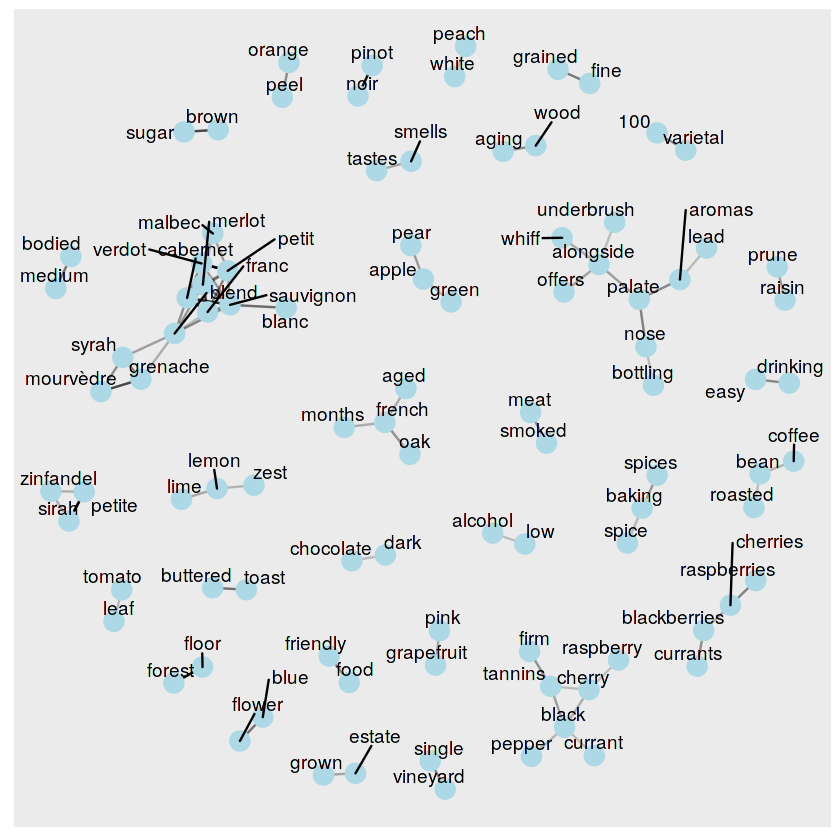

In [34]:
set.seed(2017)

ggraph(cor_graph, layout = "fr") +
  geom_edge_link(aes(edge_alpha = correlation), show.legend = F) +
  geom_node_point(color = "lightblue", size = 5) +
  geom_node_text(aes(label = name), vjust=1, hjust=1, repel = T)

We can easily see some words that are frequently used together like, low alcohol, food friendly, buttered toast...

 
Put the words into a matrix.We can easily see some words that are frequently used together like, low alcohol, food friendly, buttered toast...

 
Put the words into a matrix.

In [35]:
filtered_words <- wine_rating_words %>% 
  distinct(wine_id, word) %>% 
  add_count(word) %>% 
  filter(n >=1000,
         str_detect(word, "[a-z]")) 

In [36]:
library(Matrix)

wine_word_matrix <- filtered_words %>% 
  cast_sparse(wine_id, word)

wine_id <- as.integer(rownames(wine_word_matrix))
scores <- wine_ratings$points[wine_id]

wine_word_matrix_updated <- cbind(wine_word_matrix,log_price =log2(wine_ratings$price[wine_id] ))

We will be doing sparse regression with the glmnet package.

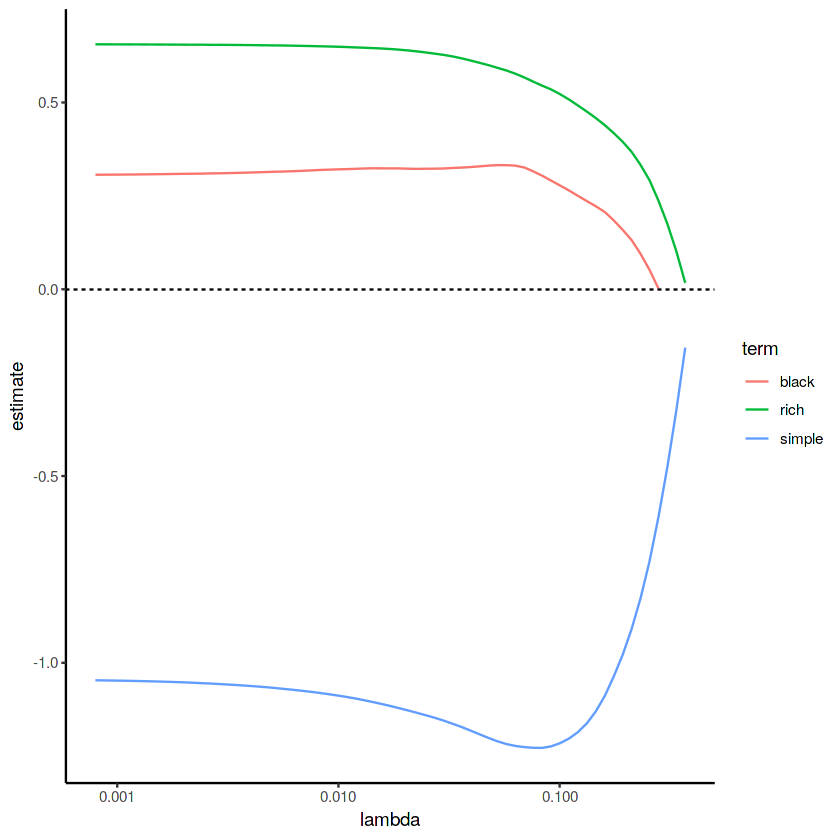

In [37]:
library(glmnet)

glmnet_model <- glmnet(wine_word_matrix_updated, scores)


library(broom)

glmnet_model %>% 
  tidy() %>% 
  filter(term %in% c("rich", "black", "simple")) %>% 
  ggplot(aes(lambda, estimate, color=term)) +
  geom_line() +
  theme_classic() +
  scale_x_log10() +
  geom_hline(lty=2, yintercept = 0)

As lamba decreases the terms get further away from zero but reach at a plateau at some point.

As lamba decreases more terms keep being added to our model.

The question we ask ourself is: **Do we want a low lamba with more  terms or a higher lamba with less terms?**

**Choosing lamba.**

We use the cross validation glmnet model.


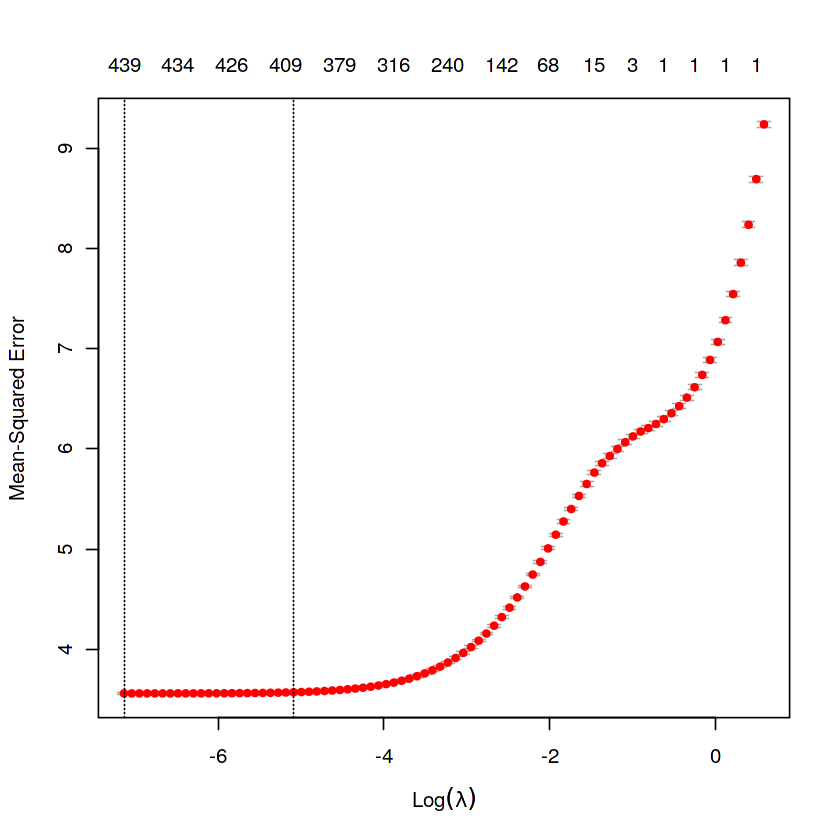

In [38]:
cv_glmnet_model <- cv.glmnet(wine_word_matrix_updated, scores)

plot(cv_glmnet_model)

This graph shows that we are not overfitting. But this doesn't show that every word has a strong impact.

In [39]:
#To get your non zero coefficients
cv_glmnet_model$glmnet.fit %>% 
  tidy() %>% 
  filter(lambda == cv_glmnet_model$lambda.1se,
         term != "(Intercept)")

term,step,estimate,lambda,dev.ratio
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
tropical,62,0.10843636,0.006167097,0.6161136
fruit,62,0.15483592,0.006167097,0.6161136
dried,62,0.04153494,0.006167097,0.6161136
herb,62,0.11926687,0.006167097,0.6161136
palate,62,0.10899852,0.006167097,0.6161136
offering,62,0.14320921,0.006167097,0.6161136
apple,62,0.15725437,0.006167097,0.6161136
citrus,62,0.27358054,0.006167097,0.6161136
sage,62,0.10435593,0.006167097,0.6161136


# What is Estimated effect of the words on the wine points?

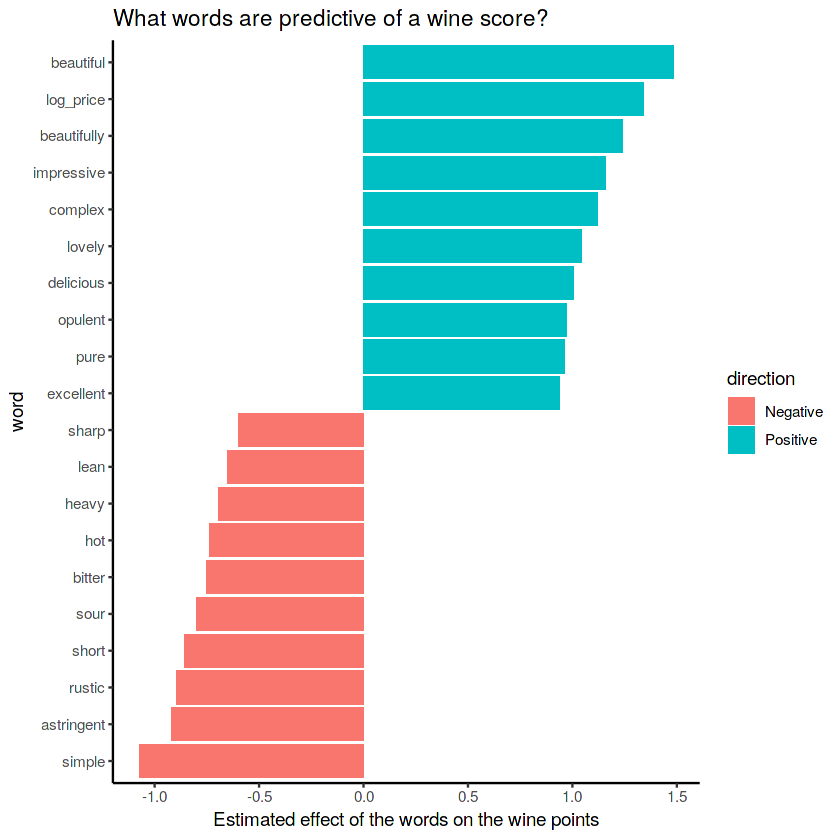

In [40]:
lexicon <-cv_glmnet_model$glmnet.fit%>% 
  tidy() %>% 
  filter(lambda == cv_glmnet_model$lambda.1se,
         term != "(Intercept)",
         term != "(log_price)") %>% 
  select(word = term, coefficient = estimate)

lexicon %>% 
  arrange(coefficient) %>% 
  group_by(direction = ifelse(coefficient < 0, "Negative", "Positive")) %>% 
  top_n(10, abs(coefficient)) %>% 
  ungroup() %>% 
  mutate(word = fct_reorder(word, coefficient)) %>% 
  ggplot(aes(word, coefficient, fill=direction)) +
  geom_col() +
  theme_classic() +
  coord_flip() +
  labs(y= "Estimated effect of the words on the wine points",
       title = "What words are predictive of a wine score?")

Words like beautiful, impressive, complex, lovely lead to a high rating of the wine.

On the other hand, words like bitter, heavy, hot lead to a negative effect on the rating of the wine.

**Variable selection**

The dataset is very large so i will filter it down.

In [41]:
top_wine <-  wine_ratings %>% 
  select(points, price, taster_name, variety, country, province, region_1,winery) %>% 
  filter(country == "Spain" | country == "France"| country == "Italy") %>% 
  mutate(price = log(price)) %>% 
  mutate_if(is.character, factor) 

# MODEL BUILDING

**Lasso regression model**

Let us divie the data into train and test.

In [42]:
set.seed(123)
wine_split <- initial_split(top_wine, prop=0.7)
wine_train <- training(wine_split)
wine_test <- testing(wine_split)

#create folds for resampling
set.seed(7654)
wine_folds <- vfold_cv(wine_train, prop = 0.7)


I will create a recipe that will do the feature engineering for us.

In [43]:
wine_rec <-recipe(points~., data = wine_train) %>% 
           step_corr(all_numeric(), -all_outcomes(), threshold = tune("num_thresh")) %>% 
           step_nzv(all_numeric(), -all_outcomes()) %>% 
           step_normalize(all_numeric(), -all_outcomes()) %>% 
           step_YeoJohnson(all_numeric(), -all_outcomes()) %>% 
           step_other(all_nominal(), threshold = tune("cat_thresh")) %>% 
           step_dummy(all_nominal())

Definition of our model.

In [44]:
linear_model <- linear_reg(penalty = tune(), mixture = 1) %>% 
                set_mode("regression") %>% 
                set_engine("glmnet")

model_metrics <- metric_set(rmse, rsq, rsq_trad, mae)

Creating a grid for our parameters.

In [45]:
linear_grid <- grid_regular(parameters(linear_model), levels = 5)

rec_grid <- grid_regular(parameters(wine_rec), levels = 5, filter = c(num_thresh > 0.7 & cat_thresh > 0.01))

#merge the two grids 
linear_rec_grid <- merge(linear_grid, rec_grid)

Tuning our parametrs.

In [46]:
set.seed(789)

doParallel::registerDoParallel()

lasso_res <- tune_grid(linear_model,
              wine_rec,
              resamples = wine_folds,
              grid = linear_rec_grid,
              metrics = model_metrics)

lasso_res %>% 
  collect_metrics() %>% 
  group_by(.metric) %>% 
   summarise(min = min(mean),
            median = median(mean),
            mean = mean(mean),
            max = max(mean))


Attaching package: ‘rlang’


The following object is masked from ‘package:igraph’:

    is_named


The following objects are masked from ‘package:purrr’:

    %@%, as_function, flatten, flatten_chr, flatten_dbl, flatten_int,
    flatten_lgl, flatten_raw, invoke, list_along, modify, prepend,
    splice



Attaching package: ‘vctrs’


The following object is masked from ‘package:dplyr’:

    data_frame


The following object is masked from ‘package:tibble’:

    data_frame


`summarise()` ungrouping output (override with `.groups` argument)



.metric,min,median,mean,max
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
mae,1.7715014,1.7944308,1.8323085,1.8323085
rmse,2.2410030,2.2697230,2.3107873,2.3107873
rsq,0.3876154,0.4013982,0.4016795,0.4016795
rsq_trad,0.2710514,0.4011138,0.3781472,0.3781472


Analysing the model

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 0.024625”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.050375”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  8.5251e-17”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 0.0025376”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“pseudoinverse used at 0.024625”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“neighborhood radius 0.050375”
Wa

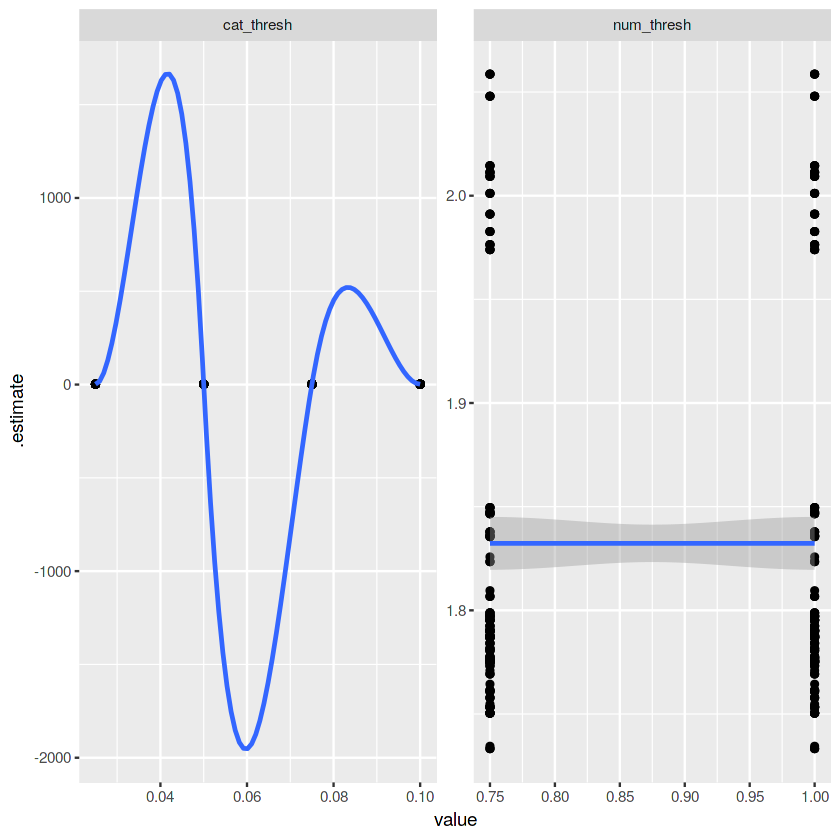

In [47]:
lasso_res %>% 
  collect_metrics(summarize = FALSE) %>% 
  pivot_longer(num_thresh : cat_thresh) %>% 
  filter(.metric == "mae") %>% 
  ggplot(aes(value, .estimate)) + 
  geom_point() + 
  geom_smooth() +
  facet_wrap(~name, scales = "free")

The categorical threshold is seasonal with it beung most effective at a value of around 0.04.

On the other hand, the numerical features threshold is constant from 0.75 upwards.


Select parameters with the best metric.

In [48]:
model_tune <- lasso_res %>% select_best("mae")

I will apply the parameters to the model.

In [49]:
linear_model <- finalize_model(linear_model, model_tune)

wine_rec <- finalize_recipe(wine_rec, model_tune)

In [50]:
ratings_model <- workflow() %>% 
  add_model(linear_model) %>% 
  add_recipe(wine_rec)

ratings_model_fit <- last_fit(ratings_model, wine_split)

In [51]:
ratings_model_fit %>% 
  collect_predictions() %>% 
  mae(.pred, points)

ratings_model_fit %>% 
  collect_metrics() %>% 
  group_by(.metric)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
mae,standard,1.767569


.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<fct>
rmse,standard,2.2448605,Preprocessor1_Model1
rsq,standard,0.4211096,Preprocessor1_Model1


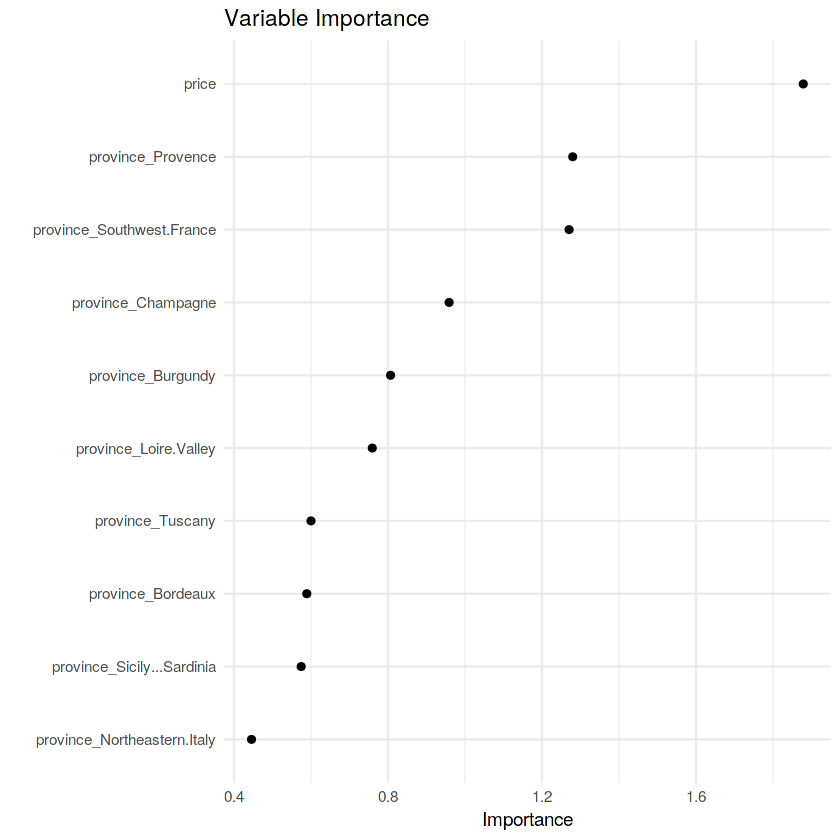

In [52]:
#Variable importance
ratings_model %>% 
  fit(data = wine_train) %>% 
  pull_workflow_fit() %>% 
  vip(geom = "point") +
  theme_minimal() +
  ggtitle("Variable Importance")

It seems our most important variables are the price and provinces.

There wasn't enough predictor variables to build a really powerful variable.